# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.37:33887")
client

Client Scheduler: tcp://10.32.16.37:33887 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 28 Cores: 56 Memory: 322.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_theta.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_salt.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_rhodts.zarr')) #typo in filename - should be 'drhodts'
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    conv_horiz_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH      (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH           (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_TH_truth   (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhods                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhodt                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [5]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [6]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [7]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [8]:
pref=2000

### Checking if `rhs` and `lhs` seem to match

In [9]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [10]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

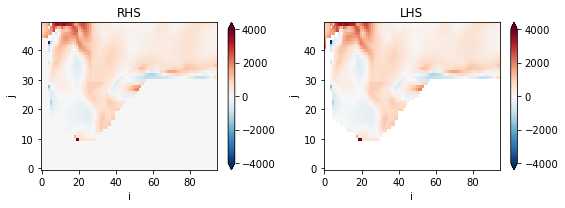

In [11]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} Combined\ terms\ for\ sigma\ ds \end{equation*} </font>

In [91]:
conv_horiz_adv_flux_SIG = ds_sig_theta.conv_horiz_adv_flux_TH + ds_sig_salt.conv_horiz_adv_flux_SLT
conv_horiz_diff_flux_SIG = ds_sig_theta.conv_horiz_diff_flux_TH + ds_sig_salt.conv_horiz_diff_flux_SLT
conv_vert_adv_flux_SIG = ds_sig_theta.conv_vert_adv_flux_TH + ds_sig_salt.conv_vert_adv_flux_SLT
conv_vert_diff_flux_SIG = ds_sig_theta.conv_vert_diff_flux_TH + ds_sig_salt.conv_vert_diff_flux_SLT
surface_flux_conv_SIG = ds_sig_theta.surface_flux_conv_TH + ds_sig_salt.surface_flux_SLT
sw_flux_salt_plume = ds_sig_theta.sw_flux_conv_TH + ds_sig_salt.salt_plume
total_tendency_SIG_truth = ds_sig_theta.total_tendency_TH_truth + ds_sig_salt.total_tendency_SLT_truth

In [92]:
ds_sig_flux_tems = xr.merge([conv_horiz_adv_flux_SIG.rename('conv_horiz_adv_flux_SIG'),
                             conv_horiz_diff_flux_SIG.rename('conv_horiz_diff_flux_SIG'),
                             conv_vert_adv_flux_SIG.rename('conv_vert_adv_flux_SIG'),
                             conv_vert_diff_flux_SIG.rename('conv_vert_diff_flux_SIG'),
                             surface_flux_conv_SIG.rename('surface_flux_conv_SIG'),
                             sw_flux_salt_plume.rename('sw_flux_salt_plume'),
                             total_tendency_SIG_truth.rename('total_tendency_SIG_truth')])

In [93]:
ds_sig = xr.merge([ds_sig_flux_tems, ds_vel, ds_drhodts])
ds_sig

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    conv_horiz_adv_flux_SIG   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SIG  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SIG    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SIG   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_SIG     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_salt_plume        (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_SIG_truth  (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    drhods                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhodt                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>

In [78]:
sigma2_snp = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT_snp, ds_tns.THETA_snp, pref,
                            output_dtypes=[ds_tns.SALT_snp.dtype],
                            dask='parallelized').reset_coords(drop=True).load()
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

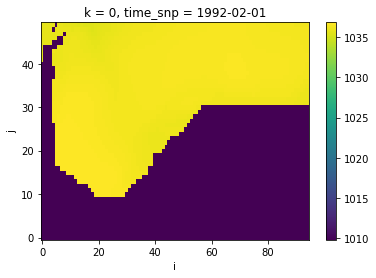

In [16]:
sigma2_snp[0,0].plot()

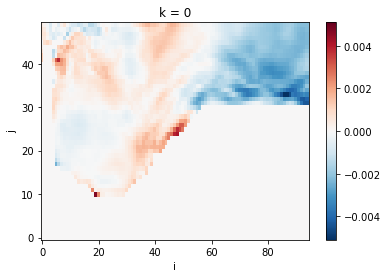

In [17]:
(sigma2.mean(dim='time')[0] - sigma2_snp.mean(dim='time_snp')[0]).plot()

In [83]:
sigma_interp = sigma2.interp(coords={'time':ds_tns.time_snp})

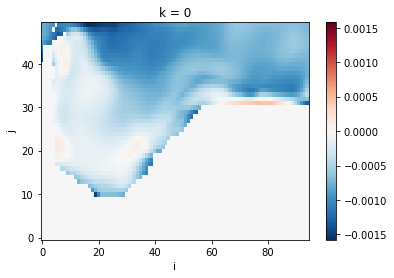

In [86]:
(sigma2.mean(dim='time')[0] - sigma_interp.mean(dim='time_snp')[0]).plot()

In [88]:
#instead of making 2 separate sigma vars for time/time_snp, interpolated sigma2 to have time_snp timestamp for vol/psi_vel terms
sigma2_snp = sigma_interp

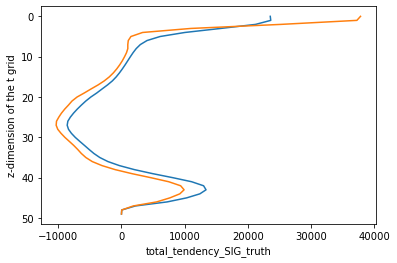

In [95]:
delta_sigma = sigma2_snp.isel(time_snp=-1) - sigma2_snp.isel(time_snp=0)
total_time = (sigma2_snp.time_snp[-1] - sigma2_snp.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
ds_sig.total_tendency_SIG_truth.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

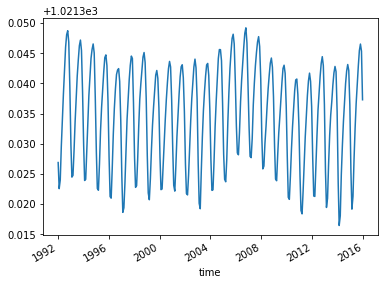

In [104]:
sigma2.mean(dim=['i', 'j', 'k']).plot()

In [145]:
# define bins
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)
#define theta_bines for WG range

In [146]:
sigma_bins.size

1000

In [199]:
vol = vol.chunk({'i':-1, 'j':-1, 'k':-1})
sigma2 = sigma2.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
sigma2_snp = sigma2_snp.chunk({'i':-1, 'j':-1, 'k':-1, 'time_snp':1})
ds_sig = ds_sig.chunk({'i':-1, 'j':-1, 'k':-1, 'i_g':-1, 'j_g':-1, 'k_l':-1, 'time':1})

In [217]:
sigma_dist = histogram(sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['i', 'j', 'k']).load()

(1036.4, 1037.4)

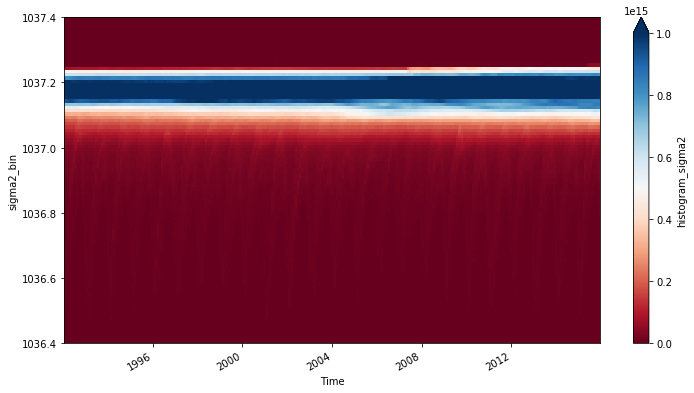

In [218]:
sigma_dist.plot(x='time_snp', figsize=(12, 6), vmax=1e15, cmap='RdBu')
plt.ylim(1036.4, 1037.4)

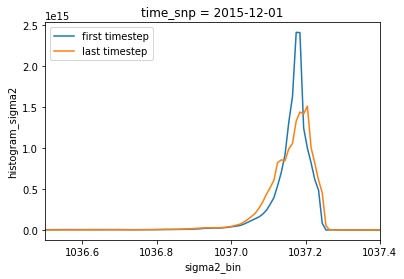

In [162]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.4);

(1036.4, 1037.4899999999911)

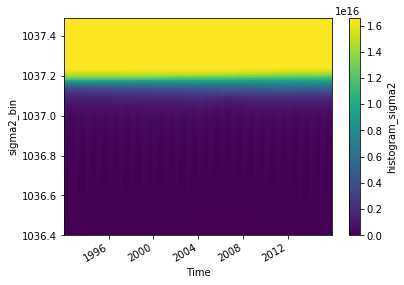

In [188]:
# cumulative volume
V = sigma_dist.cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(ymin=1036.4)

In [169]:
V

<xarray.DataArray 'histogram_sigma2' (time_snp: 287, sigma2_bin: 999)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65794167e+16, 1.65796766e+16, 1.65796766e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65795671e+16, 1.65796766e+16, 1.65796766e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796166e+16, 1.65796766e+16, 1.65796766e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16]])
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [170]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds_tns.time[1:-1].values

In [171]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time_snp: 286, sigma2_bin: 999)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.50330663e+11, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.95443231e+10, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
    time        (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [176]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds_tns.dt[1:-1]

In [177]:
dVdt

<xarray.DataArray (time: 286, sigma2_bin: 999)>
dask.array<true_divide, shape=(286, 999), dtype=float64, chunksize=(286, 999), chunktype=numpy.ndarray>
Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

(1036, 1037.5)

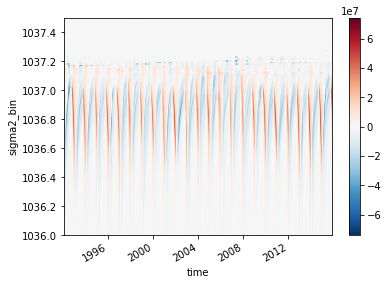

In [179]:
dVdt.plot(x='time')
plt.ylim(1036, 1037.5)

## $\Omega_{total}$

In [190]:
sigma2.coords

Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [201]:
omega_total = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds_sig.total_tendency_SIG_truth.fillna(0.),
                          dim=['i', 'j', 'k']) / delta_sigma
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 999)>
array([[    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
         33545.06673459,  26821.82497373,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -50551.06178259, -14963.32736113,     -0.        ],
       ...,
       [    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

(1036, 1037.4899999999911)

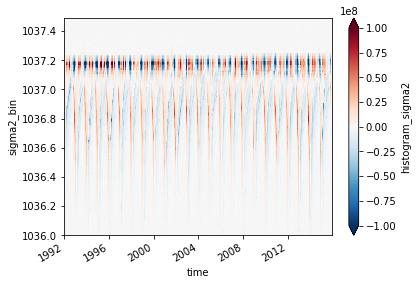

In [204]:
omega_total.plot(x='time', vmax=1e8)
plt.ylim(ymin=1036)

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

In [205]:
dVdt

<xarray.DataArray (time: 286, sigma2_bin: 999)>
dask.array<true_divide, shape=(286, 999), dtype=float64, chunksize=(286, 999), chunktype=numpy.ndarray>
Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

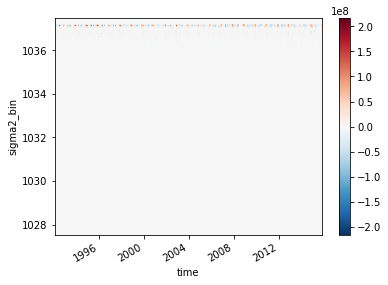

In [208]:
R1 = dVdt - omega_total[1:-1]
R1.plot(x='time')

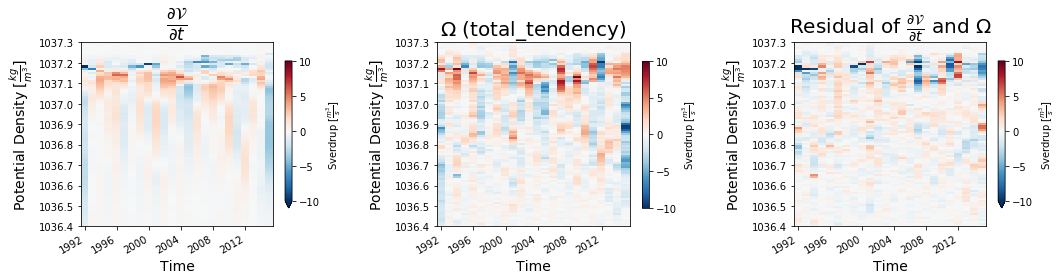

In [221]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0, vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)
ax0.set_ylim(1036.4, 1037.3)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)
ax1.set_ylim(1036.4, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)
ax2.set_ylim(1036.4, 1037.3)

plt.tight_layout();

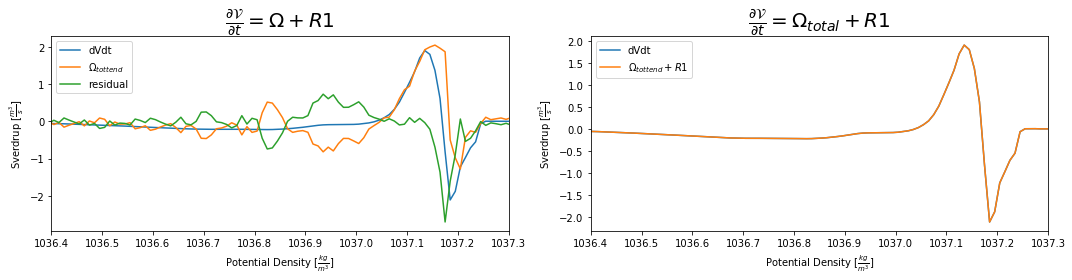

In [226]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20)
ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20)
ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [227]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / delta_sigma

In [280]:
#slicing ds_sig to just have tendency terms
data_vars = list(ds_sig.data_vars.keys())
tendency_vars = data_vars[:-5]

for var in tendency_vars:
    ds_sig_tendencies[var] = ds_sig[var] 

In [282]:
#resetting the new terms to be data vars and not coords
wanted_vars = [dvar for dvar in ds_sig_tendencies.coords
               if dvar != 'time' and dvar != 'k']
ds_sig_tendencies.reset_coords()

<xarray.Dataset>
Dimensions:                   (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SIG   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SIG  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SIG    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SIG   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_SIG     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_salt_plume        (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_SIG_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>

In [286]:
all_dsets = xr.merge([histogram_func(ds_sig_tendencies[var]).rename('OMEGA_' + var)
                      for var in tendency_vars])
all_dsets

<xarray.Dataset>
Dimensions:                         (sigma2_bin: 999, time: 288)
Coordinates:
  * time                            (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * sigma2_bin                      (sigma2_bin) float64 1.028e+03 ... 1.037e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_SIG   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SIG  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SIG    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SIG   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_conv_SIG     (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_sw_flux_salt_plume        (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_total_tendency_SIG_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>

(1036.4, 1037.3)

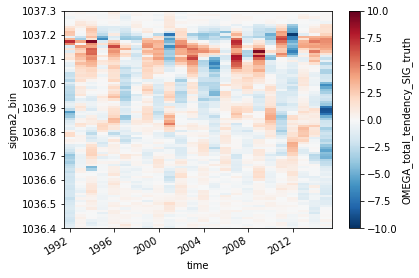

In [289]:
#checking to see if it looks the same as omega_total subplot above (and it does!)
(-all_dsets.OMEGA_total_tendency_SIG_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time', vmax=10)
plt.ylim(1036.4, 1037.3)

In [290]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_SIG + 
                      all_dsets.OMEGA_conv_vert_diff_flux_SIG +
                      all_dsets.OMEGA_sw_flux_salt_plume + 
                      all_dsets.OMEGA_surface_flux_conv_SIG)
omega_trans_rate.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[  -0.        ,   -0.        ,   -0.        , ...,   -0.        ,
        7053.51897715,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        , ..., 3353.99507132,
        3728.73846562,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        , ..., 5728.49154861,
        1366.80802701,   -0.        ],
       ...,
       [  -0.        ,   -0.        ,   -0.        , ...,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        , ...,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        , ...,   -0.        ,
          -0.        ,   -0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

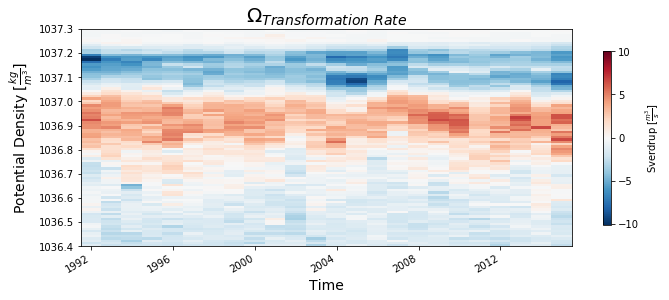

In [292]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(11,4), 
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Omega_{Transformation\ Rate}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [339]:
psi_adv = -(all_dsets.OMEGA_conv_horiz_adv_flux_SIG + all_dsets.OMEGA_conv_vert_adv_flux_SIG)
psi_adv.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[    -0.        ,     -0.        ,     -0.        , ...,
            -0.        , -26949.34652114,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
         29706.12442714,  22597.47150085,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -57095.28114015, -16490.84841535,     -0.        ],
       ...,
       [    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ],
       [    -0.        ,     -0.        ,     -0.        , ...,
            -0.        ,     -0.        ,     -0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

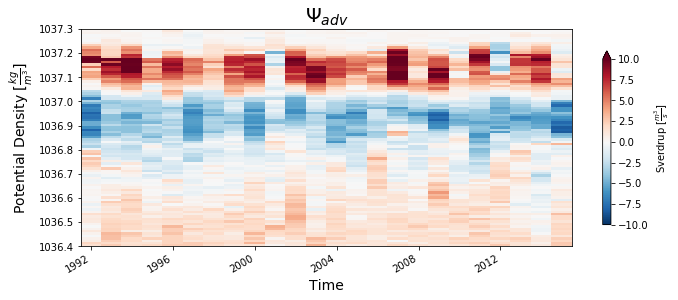

In [295]:
(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Psi_{adv}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

## $\Psi_{vel}$

In [296]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=0)
v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(k_l=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [329]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

In [330]:
v_transport_mean_value = v_transport.mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [331]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [332]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [333]:
# hack theta to be on same grid pt as velocity components
sigma_at_u_right = sigma2.isel(i=-1)
sigma_at_u_left = sigma2.isel(i=0)
sigma_at_v = sigma2.isel(j=-1)
sigma_at_w = sigma2.isel(k=0)

In [334]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma'), bins=[sigma_bins],
                     weights=u_transport_right, dim=['k', 'j'])
u_binned_left = histogram(sigma_at_u_left.rename('sigma'), bins=[sigma_bins],
                     weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(sigma_at_v.rename('sigma'), bins=[sigma_bins],
                     weights=v_transport.chunk({'i':-1}), dim=['k', 'i'])
w_binned = histogram(sigma_at_w.rename('sigma'), bins=[sigma_bins],
                     weights=w_transport.chunk({'i':-1}), dim=['i', 'j'])

In [335]:
psi_vel = -(u_binned_right + u_binned_left + v_binned).cumsum(dim='sigma_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma' (time: 288, sigma_bin: 999)>
array([[       -0.        ,        -0.        ,        -0.        , ...,
        -30604726.66082716, -30604726.66082716, -30604726.66082716],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -27805344.78760284, -27805344.78760284, -27805344.78760284],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -32200995.03842318, -32200995.03842318, -32200995.03842318],
       ...,
       [       -0.        ,        -0.        ,        -0.        , ...,
        -33500931.14900935, -33500931.14900935, -33500931.14900935],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -29893546.89956188, -29893546.89956188, -29893546.89956188],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -28088308.78935134, -28088308.78935134, -28088308.78935134]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma_bin  (sigma_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

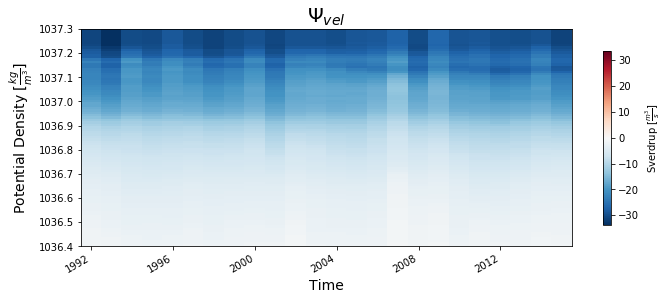

In [336]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

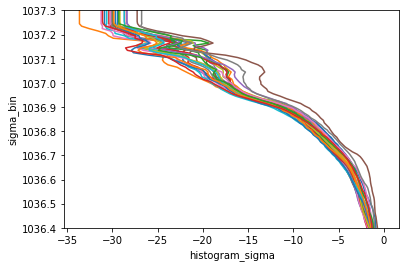

In [337]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma_bin', add_legend=False)
plt.ylim(1036.4, 1037.3);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [ ]:
R2 = psi_adv - psi_vel
(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'Residual of $\Psi_{adv}$ and $\Psi_{vel}$', fontsize=20);

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\Psi_{adv}$', fontsize=24)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Psi_{vel}$', fontsize=20)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$', fontsize=20)

plt.tight_layout();

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

(psi_adv/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>